In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import train, predict
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, show_errors, most_confused_classes,\
    most_inaccurate_k_classes
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

16980

# Model

In [6]:
from get_resnet18_with_sd import get_model

In [7]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [8]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))

In [9]:
# number of params in the model
count_params(model)

11307840

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 40
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=4, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

n_batches

531

In [11]:
%%time
all_losses, _ = train(
    model, criterion, optimizer, 
    train_iterator, n_epochs, n_batches, 
    val_iterator, validation_step=531, n_validation_batches=80, 
    saving_step=None, lr_scheduler=lr_scheduler
)

1.00  4.589 4.205  0.183 0.296  0.354 0.517  94.944
2.00  3.407 2.729  0.373 0.547  0.614 0.786  94.347
3.00  3.021 2.382  0.452 0.608  0.689 0.837  94.065
4.00  2.850 1.919  0.485 0.648  0.719 0.855  93.963
5.00  2.835 2.368  0.480 0.623  0.712 0.835  93.980
6.00  2.696 3.042  0.509 0.583  0.733 0.797  93.878
7.00  2.564 2.586  0.537 0.585  0.761 0.825  94.029
8.00  2.440 2.644  0.547 0.621  0.769 0.831  93.688
9.00  2.334 1.940  0.568 0.649  0.784 0.856  94.058
Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch     8: reducing learning rate of group 1 to 1.0000e-03.
Epoch     8: reducing learning rate of group 2 to 1.0000e-04.
Epoch     8: reducing learning rate of group 3 to 1.0000e-04.
Epoch     8: reducing learning rate of group 4 to 1.0000e-04.
10.00  1.968 2.220  0.648 0.698  0.838 0.882  93.892
11.00  1.910 3.258  0.660 0.614  0.844 0.827  93.775
12.00  2.040 1.527  0.652 0.741  0.840 0.911  93.696
13.00  1.889 1.505  0.666 0.752  0.840 0.916  93.652
14.00  1.9

# Loss/epoch plots

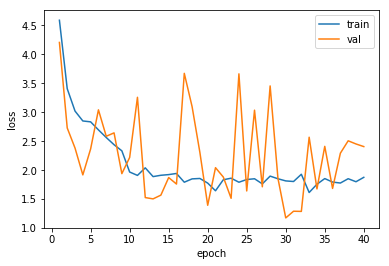

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

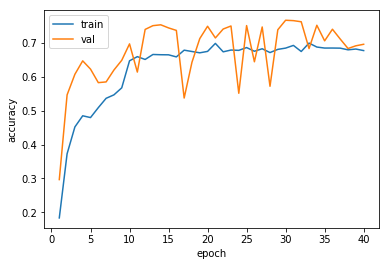

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

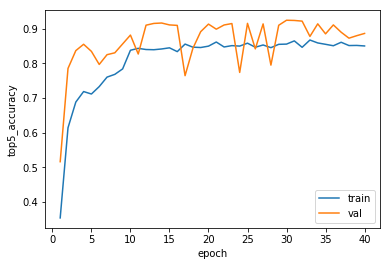

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Error analysis

### get human readable class names

In [15]:
# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}

### get all predictions and all misclassified images 

In [16]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [17]:
val_predictions, val_true_targets,\
    erroneous_samples, erroneous_targets,\
    erroneous_predictions = predict(model, val_iterator_no_shuffle, return_erroneous=True)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

100%|██████████| 80/80 [00:19<00:00,  4.21it/s]


### number of misclassified images (there are overall 5120 images in the val dataset)

In [18]:
n_errors = len(erroneous_targets)
n_errors

1553

### logloss and accuracies

In [19]:
log_loss(val_true_targets, val_predictions)

2.3964005109257869

In [20]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.69667968749999998

In [21]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.7919921875, 0.837890625, 0.86855468749999998, 0.88671875, 0.92714843749999998]


### entropy of predictions

In [22]:
hits = val_predictions.argmax(1) == val_true_targets

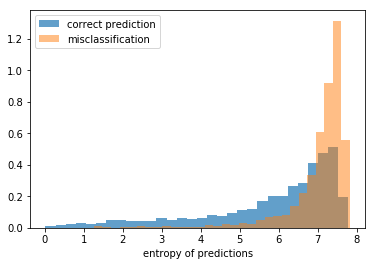

In [23]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

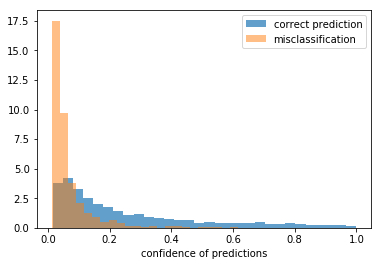

In [24]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

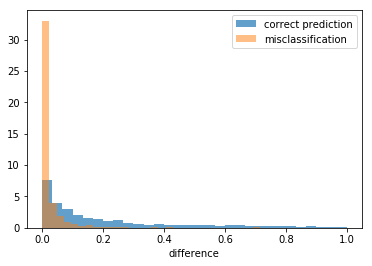

In [25]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

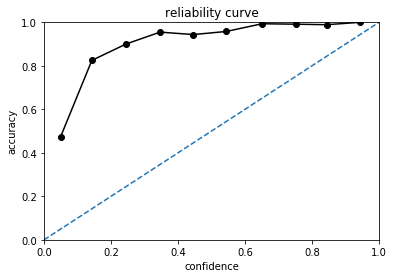

In [26]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

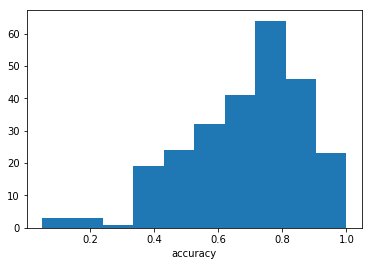

In [27]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [28]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

faces-easy 0.05
knife 0.1
playing-card 0.1
mailbox 0.15
drinking-straw 0.2
bat 0.2
coffin 0.25
mussels 0.35
canoe 0.35
rifle 0.35
tambourine 0.35
boom-box 0.35
stirrups 0.35
sneaker 0.35
spoon 0.35


### class accuracy vs. number of samples in the class

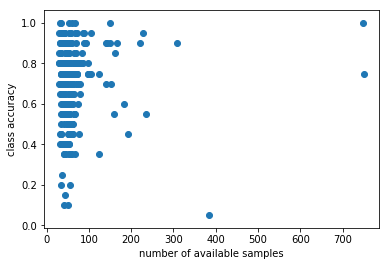

In [29]:
plt.scatter((1.0/w), per_class_acc);
plt.ylabel('class accuracy');
plt.xlabel('number of available samples');

### most confused pairs of classes

In [30]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('beer-mug', 'coffee-mug'),
 ('horse', 'unicorn'),
 ('ice-cream-cone', 'drinking-straw'),
 ('iris', 'cactus'),
 ('kayak', 'snowmobile'),
 ('kayak', 'speed-boat'),
 ('kayak', 'canoe'),
 ('killer-whale', 'dolphin'),
 ('laptop', 'computer-keyboard'),
 ('mountain-bike', 'touring-bike'),
 ('paper-shredder', 'breadmaker'),
 ('people', 'faces-easy'),
 ('boom-box', 'vcr'),
 ('screwdriver', 'syringe'),
 ('screwdriver', 'tuning-fork'),
 ('skyscraper', 'smokestack'),
 ('sneaker', 'tennis-shoes'),
 ('swan', 'duck'),
 ('swan', 'goose'),
 ('breadmaker', 'washing-machine'),
 ('tambourine', 'frisbee'),
 ('touring-bike', 'tricycle'),
 ('tweezer', 'chopsticks'),
 ('yarmulke', 'frisbee'),
 ('yo-yo', 'frisbee'),
 ('cd', 'frisbee'),
 ('chimp', 'gorilla'),
 ('comet', 'galaxy'),
 ('duck', 'goose'),
 ('elk', 'goat')]

### show some low entropy errors

In [31]:
erroneous_entropy = entropy(erroneous_predictions)
mean_entropy = erroneous_entropy.mean()
low_entropy = mean_entropy < erroneous_entropy
mean_entropy

7.0525567690469098

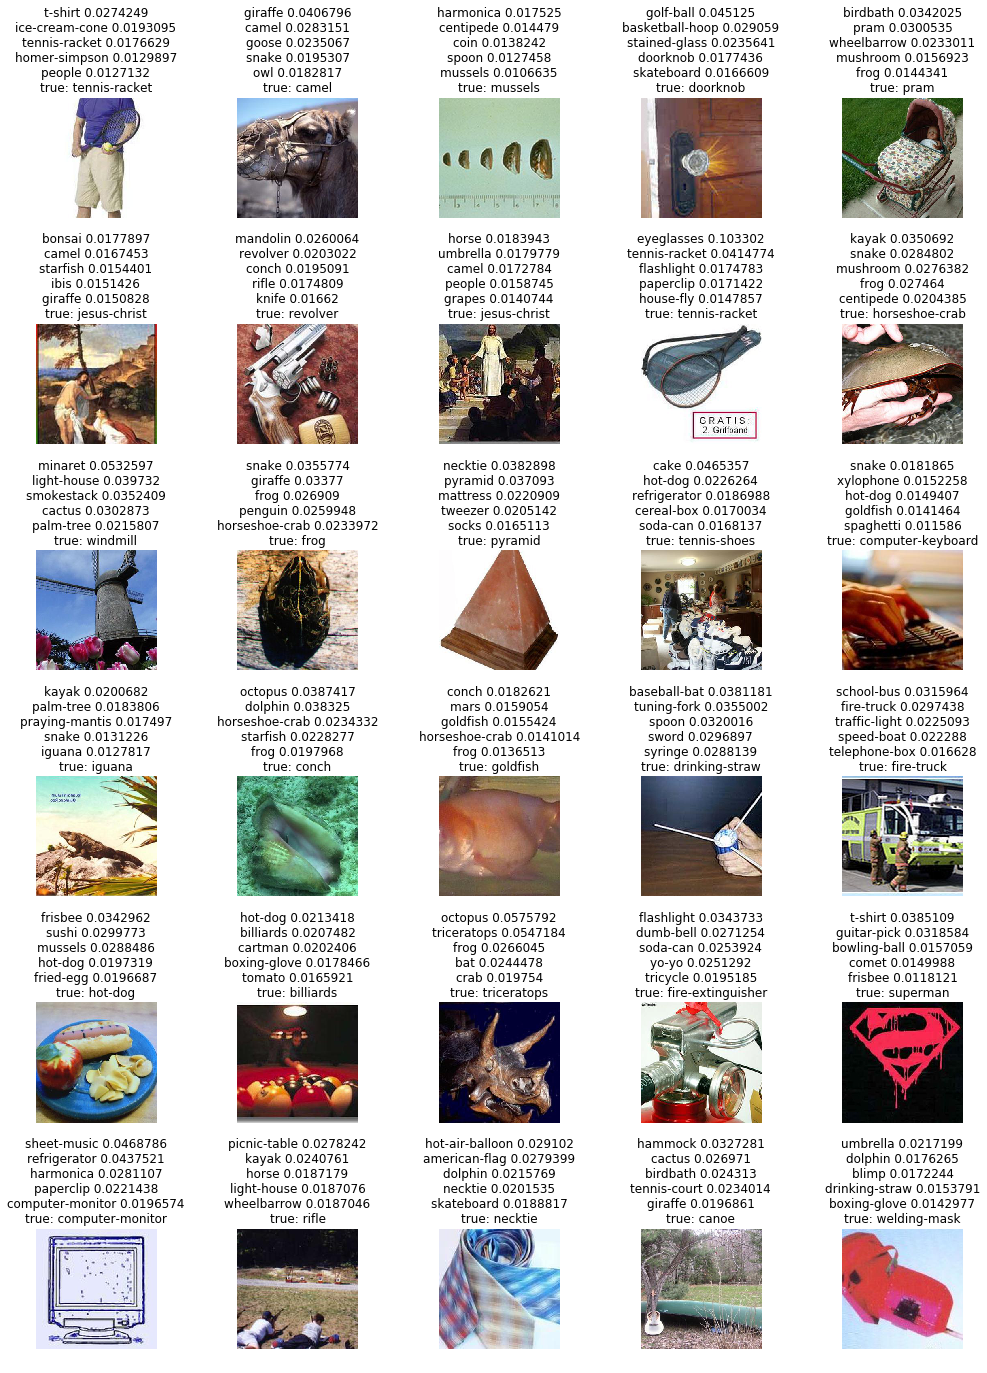

In [32]:
show_errors(
    erroneous_samples[low_entropy], 
    erroneous_predictions[low_entropy], 
    erroneous_targets[low_entropy], 
    decode
)

### show some high entropy errors

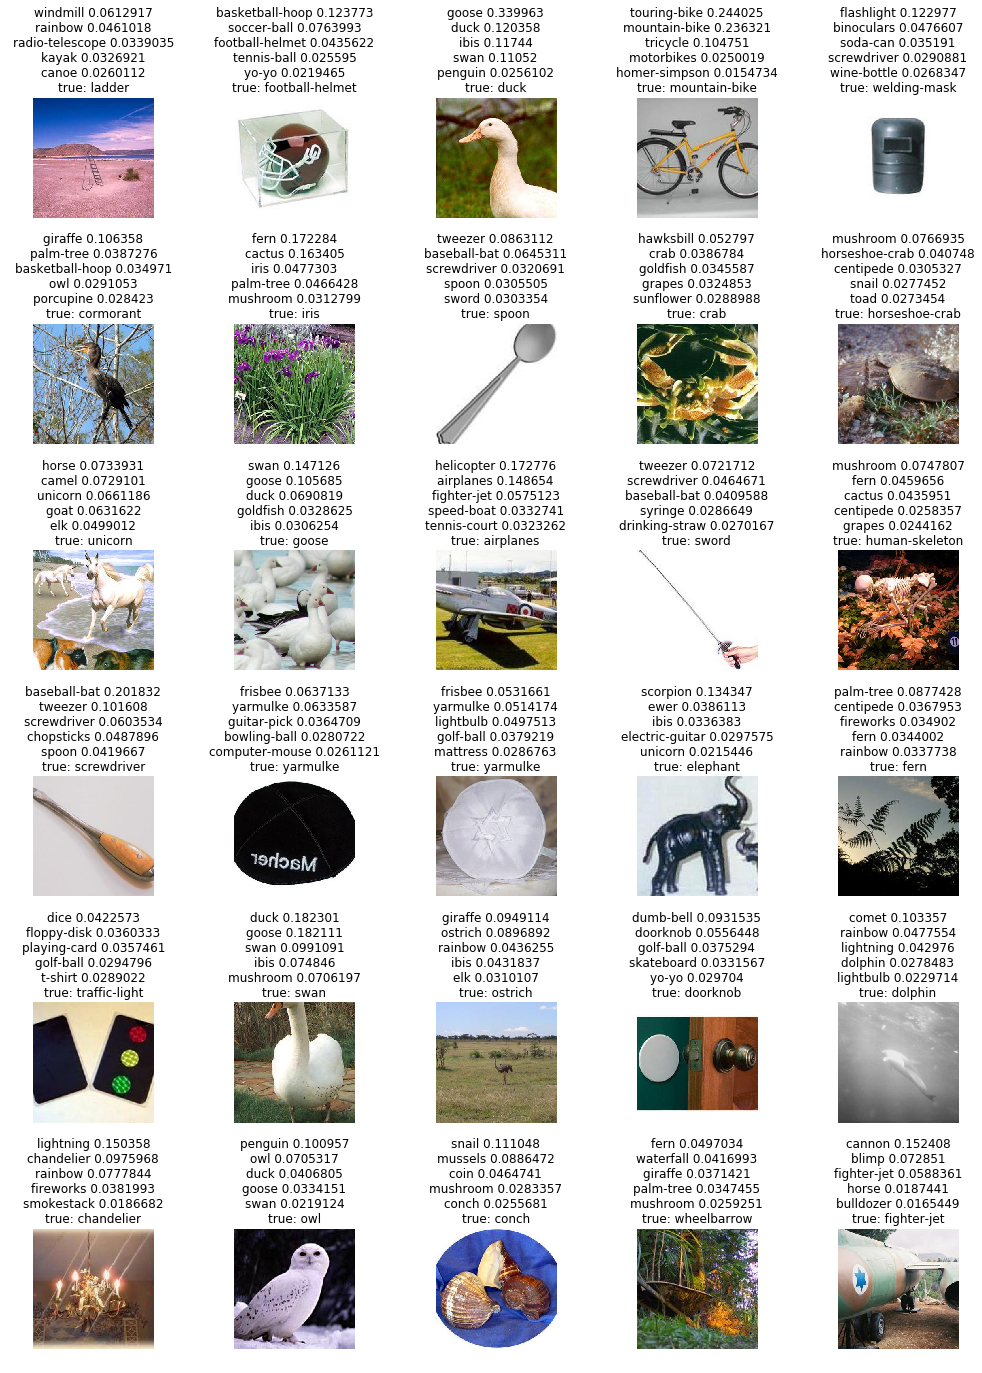

In [33]:
show_errors(
    erroneous_samples[~low_entropy], 
    erroneous_predictions[~low_entropy], 
    erroneous_targets[~low_entropy], 
    decode
)

# Save

In [34]:
model.cpu();
torch.save(model.state_dict(), 'resnet18_with_sd.pytorch_state')